#Creating Dataset

In [1]:
!pip install ipympl==0.9.3 ipywidgets==8.1.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: ipympl
    Found existing installation: ipympl 0.9.8
    Uninstalling ipympl-0.9.8:
      Successfully uninstalled ipympl-0.9.8


In [2]:
## Install packages
!pip install matplotlib git+https://github.com/facebookresearch/segment-anything.git opencv-python pycocotools

## Enable widget manager (required for ipympl)
from google.colab import output
output.enable_custom_widget_manager()

## Use the correct matplotlib backend
#%matplotlib inline  # or %matplotlib ipympl  if you want interactive plots
%matplotlib ipympl
## Download the Segment Anything Model
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Download sample images
!wget -q https://raw.githubusercontent.com/eric-yim/streaming-people-counter/main/people_sample.png
!wget -q https://raw.githubusercontent.com/eric-yim/streaming-people-counter/main/road.png

## Import libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

## Define visualization helpers
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*',
               s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*',
               s=marker_size, edgecolor='white', linewidth=1.25)

def show_point(coords, label, ax, marker_size=100):
    color = 'green' if label == 1 else 'red'
    ax.scatter([coords[0]], [coords[1]], color=color, marker='*',
               s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h,
                               edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_boxes(boxes, ax):
    for box in boxes:
        show_box(box, ax)


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-i4l7_diu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-i4l7_diu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


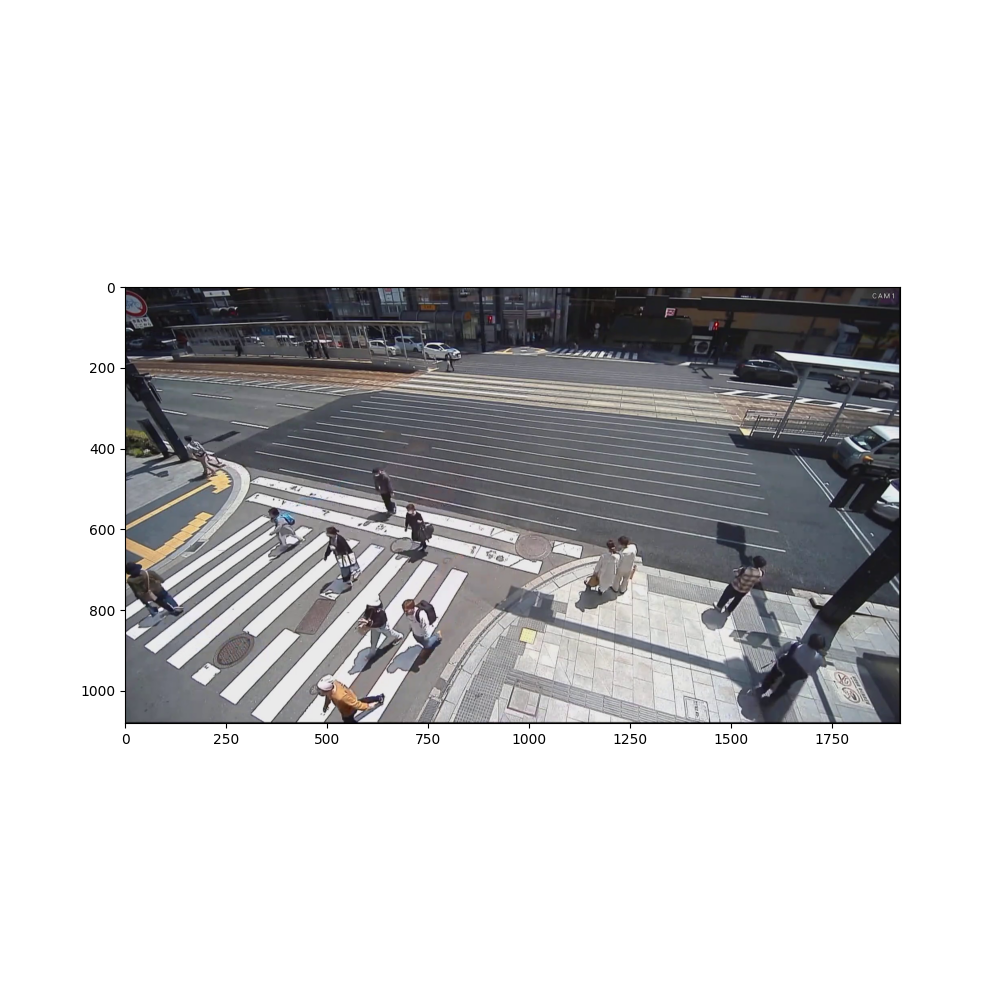

In [3]:
# Load and display image

image = cv2.imread("/content/people_sample.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

###Manual Labeling


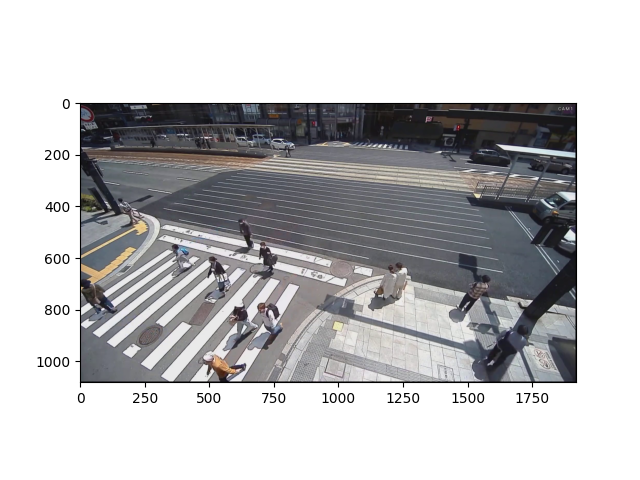

In [4]:
BOUNDING_BOXES = []
CLICKED_POINTS = []
plt.clf()
fig, AX = plt.subplots()

AX.imshow(image)
def onclick(event):
    global CLICKED_POINTS, AX, image
    ix, iy = event.xdata, event.ydata
    if ix and iy:
      CLICKED_POINTS.append([ix,iy])
    # When we have 2 points, that defines a box. We add that to our list of boxes
    if len(CLICKED_POINTS)==2:
      top_left = [min(CLICKED_POINTS[0][0],CLICKED_POINTS[1][0]),
                  min(CLICKED_POINTS[0][1],CLICKED_POINTS[1][1])]
      bottom_right = [max(CLICKED_POINTS[0][0],CLICKED_POINTS[1][0]),
                  max(CLICKED_POINTS[0][1],CLICKED_POINTS[1][1])]
      BOUNDING_BOXES.append(top_left+bottom_right)
      CLICKED_POINTS = []
      AX.cla()
      AX.imshow(image)
      show_boxes(BOUNDING_BOXES,AX)
    elif len(CLICKED_POINTS)==1:
      show_point(CLICKED_POINTS[0],1,AX)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [5]:
print("Here are the coordinates for all the boxes you have prepared.")
print("There should be 4 values, which are the top, left and bottom, right of your boxes\n")
for box in BOUNDING_BOXES:
  print(box)

Here are the coordinates for all the boxes you have prepared.
There should be 4 values, which are the top, left and bottom, right of your boxes

[np.float64(585.8450834879407), np.float64(427.3540507111935), np.float64(672.4251700680272), np.float64(558.4610389610389)]
[np.float64(348.36827458256033), np.float64(531.2501546072974), np.float64(439.895794681509), np.float64(640.0936920222633)]
[np.float64(479.4752628324057), np.float64(595.5667903525045), np.float64(595.7399505256649), np.float64(724.2000618429189)]
[np.float64(4.521645021645043), np.float64(684.6205936920222), np.float64(143.04978354978357), np.float64(793.4641311069881)]
[np.float64(140.5760667903525), np.float64(363.0374149659863), np.float64(227.15615337043909), np.float64(454.56493506493496)]
[np.float64(689.7411873840447), np.float64(536.1975881261595), np.float64(754.0578231292518), np.float64(640.0936920222633)]
[np.float64(598.2136672850959), np.float64(761.3058132343846), np.float64(674.8988868274582), np.float

###AI Assisted Labeling

In [6]:
# Load the Segment Anything model
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Load image again
image = cv2.imread('people_sample.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

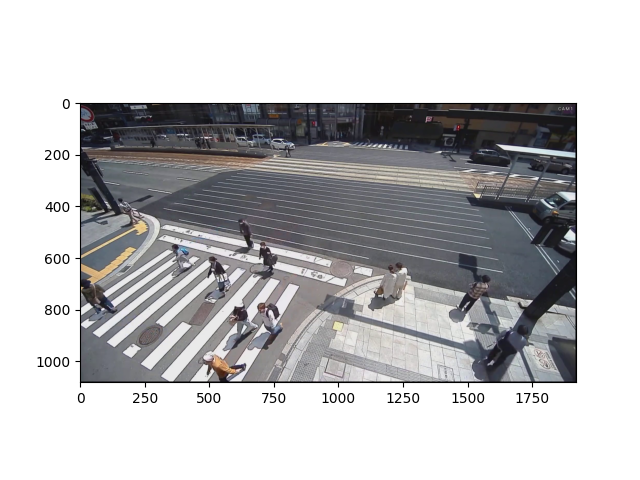

In [7]:
BUFFER=10
CLICKED_POINTS = []
MASKS = []
MASK=None
plt.clf()
fig, AX = plt.subplots()

AX.imshow(image)
def create_index_meshgrid(rows,cols):
    # Create a 2D array using meshgrid
    x, y = np.meshgrid(np.arange(cols),np.arange(rows))

    # Stack the x and y arrays along the third axis to create a 3D array
    result = np.stack((x, y), axis=-1)
    return result
def get_mask(input_point,input_label,out_type='rand'):
    assert out_type in {'rand','best','all'}
    masks, scores, logits = predictor.predict(
      point_coords=input_point,
      point_labels=input_label,
      multimask_output=True
    )
    if out_type=='rand':
      i = np.random.randint(0,len(masks))
      return masks[i]
    elif out_type=='best':
      i = np.argmax(scores,axis=0)
      return masks[i]
    return masks
def get_box_from_mask(mask):
    global BUFFER
    h,w = mask.shape[:2]
    mgrid = create_index_meshgrid(h,w)
    inds = mgrid[mask]
    minx = max(np.min(inds[:,0])-BUFFER,0)
    miny = max(np.min(inds[:,1])-BUFFER,0)
    maxx = min(np.max(inds[:,0])+BUFFER,w)
    maxy = min(np.max(inds[:,1])+BUFFER,h)
    return [minx,miny,maxx,maxy]
def onclick(event):
    global CLICKED_POINTS, AX, image,MASK,MASKS
    ix, iy = event.xdata, event.ydata
    AX.cla()
    AX.imshow(image)
    if ix and iy:
      if event.button==1:
        CLICKED_POINTS.append([ix,iy])
        MASK= get_mask(np.array([[ix,iy]]),np.arange(1)+1,'rand')
        show_mask(MASK,AX)
        show_point([ix,iy],1,AX)
      elif event.button==3:
        if MASK is not None:

          MASKS.append(MASK)
    boxes = [get_box_from_mask(mask) for mask in MASKS]
    show_boxes(boxes,AX)



cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [10]:
print(f"You have {len(MASKS)} masks, with shape: {MASKS[0].shape}.")
print("Here are the boxes associated with each mask.\n")
boxes = [get_box_from_mask(mask) for mask in MASKS]
for box in boxes:
  print(box)

You have 10 masks, with shape: (1080, 1920).
Here are the boxes associated with each mask.

[np.int64(684), np.int64(547), np.int64(749), np.int64(625)]
[np.int64(688), np.int64(784), np.int64(777), np.int64(900)]
[np.int64(1151), np.int64(648), np.int64(1235), np.int64(762)]
[np.int64(1197), np.int64(607), np.int64(1277), np.int64(771)]
[np.int64(1454), np.int64(656), np.int64(1597), np.int64(822)]
[np.int64(466), np.int64(952), np.int64(652), 1080]
[np.int64(483), np.int64(583), np.int64(588), np.int64(751)]
[np.int64(345), np.int64(535), np.int64(445), np.int64(683)]
[np.int64(137), np.int64(359), np.int64(227), np.int64(477)]
[0, np.int64(689), np.int64(128), np.int64(801)]


###Synthetic Data Augmentation

In [11]:
print(f"You have {len(MASKS)} masks, with shape: {MASKS[0].shape}.")

You have 10 masks, with shape: (1080, 1920).


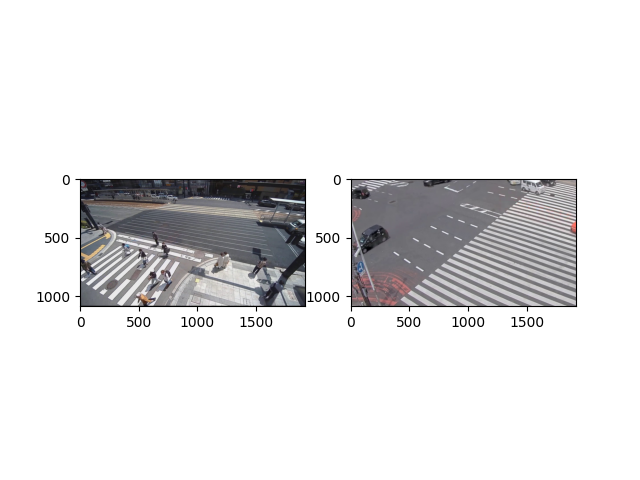

In [12]:
# Load image again
source_image = cv2.cvtColor(cv2.imread('people_sample.png'), cv2.COLOR_BGR2RGB)
# Load new background
target_image = cv2.cvtColor(cv2.imread('road.png'), cv2.COLOR_BGR2RGB)

plt.clf()
fig, axes = plt.subplots(1,2)
axes[0].imshow(source_image)
axes[1].imshow(target_image)

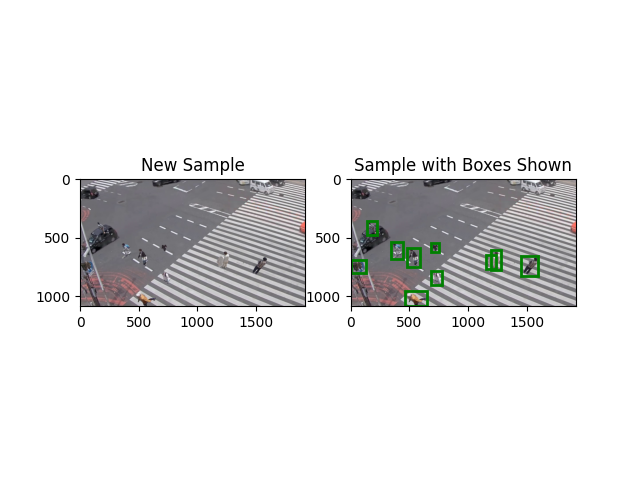

In [13]:
def create_synthetic_sample(source,target,masks):
    h,w = source.shape[:2]
    new = target.copy()
    new = cv2.resize(new,(w,h))
    for mask in masks:
      new[mask]=source[mask]
    return new
sample = create_synthetic_sample(source_image,target_image,MASKS)
cv2.imwrite('synthetic_sample.png',cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.clf()
fig, axes = plt.subplots(1,2)
axes[0].imshow(sample)
axes[0].set_title("New Sample")
axes[1].imshow(sample)
axes[1].set_title("Sample with Boxes Shown")
boxes = [get_box_from_mask(mask) for mask in MASKS]
show_boxes(boxes,axes[1])


###Create annotation in coco format

In [14]:
images = [
  {
    "file_name": "people_sample.png",
    "height": 1080,
    "width": 1920,
    "id": 0
  },
  {
    "file_name": "synthetic_sample.png",
    "height": 1080,
    "width": 1920,
    "id": 1
  }
]
categories = [
  {
    "supercategory": "person",
    "id": 0,
    "name": "person"
  }
]

In [15]:
import json
annotations = []
for img in images:
  boxes = [get_box_from_mask(mask) for mask in MASKS]
  for box in boxes:
    x0,y0,x1,y1 = map(float,box)
    w = x1-x0
    h = y1-y0
    annotation = {
        "segmentation": [],
        "area": w*h,    # pixel area of detection
        "iscrowd": 0,
        "image_id": img["id"],   # Matches an image's id
        "bbox": [x0,y0,w,h],   #top left, w h
        "category_id": categories[0]["id"] ,    # Matches a category's id
        "id": len(annotations)    # A unique number
      }
    annotations.append(annotation)
print(f"You have {len(annotations)} annotations. The first looks like this:\n\n")
print(json.dumps(annotations[0],indent=2))

You have 20 annotations. The first looks like this:


{
  "segmentation": [],
  "area": 5070.0,
  "iscrowd": 0,
  "image_id": 0,
  "bbox": [
    684.0,
    547.0,
    65.0,
    78.0
  ],
  "category_id": 0,
  "id": 0
}


In [16]:
save_location = "annotations.json"
print(f"Saving to disk at {save_location}")
full_dump = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}
json.dump(full_dump,open(save_location,'w'),indent=2)

Saving to disk at annotations.json


In [17]:
print(f"Congratulations! You now have a dataset with {len(images)} images and {len(annotations)} in the COCO format!\nThis dataset can be used to train an Object Detector!")

Congratulations! You now have a dataset with 2 images and 20 in the COCO format!
This dataset can be used to train an Object Detector!
